In [1]:
import numpy as np
from scipy.integrate import odeint
from matplotlib import pyplot as plt
import sympy as sy
np.set_printoptions(precision=4)
from functools import partial
from tqdm import tqdm

In [2]:
#%matplotlib inline
def pltAttr(x='', y='', title=None, legend=None, save=None):
    plt.tight_layout()
    if legend is not None:
        plt.legend(loc=legend)
    plt.xlabel(x)
    plt.ylabel(y)
    if title is not None:
        plt.title(title)
    if save is not None:
        plt.savefig(save)

These are the equations for the ODE

In [3]:
# define state equations
def ode(y,t, lambda_):
    x = y[0]
    v = y[1]
    p1 = y[2]
    p2 = y[3]
    
    #calculate various things
    fp_x = fp_lam(x)
    normp_x = normp_lam(x)
    fp_normp_x = fp_normp_lam(x)
    u = np.clip(p2*max_u**2 / (2*(1-lambda_)), min_u, max_u)

    #find vdot and pdot
    xdot = v / np.sqrt(1 + fp_x**2)
    vdot = u - g*fp_x / np.sqrt(1 + fp_x**2)
    pd1 = -p1*v*normp_x + p2*g*fp_normp_x
    pd2 = -p1/np.sqrt(1+fp_x**2)
    
    return np.array([xdot, vdot, pd1, pd2])

This is the function we want to find 0's of.  
We put in initial conditions for p1 and p2, and get out final condition on x and v  
We want to find which initial conditions for p1 and p2 gives out 0s for x and v  

In [4]:
def func(p, tf=5, lambda_=1/2):
    return odeint(ode, np.array([x0, v0, p[0], p[1]]), [t0,tf], (lambda_,), atol=1e-10)[1,0:2]

This is the algorithm for finding our roots. It requires a initial derivative and guess as a first estimate.

In [5]:
def find_zero(f, p0, Df, alpha, maxI, tf=None, display=True):
    if display:
        loop = tqdm(total=maxI, position=0, leave=True)
    
    f_p1 = np.inf
    i = 0
    while np.linalg.norm(f_p1) > 10**-5 and i < maxI:
        #compute solution
        f_p0 = f(p0)

        #update guess
        p1 = p0 - alpha*(np.linalg.inv(Df)@f_p0)
        
        #update derivative
        f_p1 = f(p1)
        s = p1-p0
        y = f_p1 - f_p0
        Df = Df + np.outer(y-Df@s, s) / s@s
        
        #update values
        if display:
            loop.set_description(f'tf: {np.round(tf,4)}, x0,v0: {f_p1}, p0: {p1}')
            loop.update(1)
        p0 = p1
        i = i+1
        
    if i == maxI:
        return None
    if display:
        loop.close()
    return p1

This function computes all costs across a range of ending times T. It does it by:  
  1. Using first value of T
    1. Find actual p0 using shooting method and using given guess p0
    2. Use that initial p0 to solve for control
    3. Saves cost/control
  2. For rest of values in T (as far as the shooting method allows, it'll fail once a control isn't posisble), do steps A-C using previous found p0 as guess
  3. Return all costs and p0s

In [152]:
def find_costs(p0, T, func, lambda_, display=True):
    p0s = np.zeros((len(T)+2,2))
    p0s[0] = p0
    p0s[1] = p0
    cost = np.zeros_like(T)

    for i, tf in enumerate(T):
        func_tf = partial(func, tf=tf, lambda_=lambda_)

        #use finite difference to estimate derivative
        p0 = 2*p0s[i+1] - p0s[i]
        Df = np.zeros((2,2))
        h = 1e-4
        #d/dp1
        Df[:,0] = (func_tf(p0 + np.array([h,0])) - func_tf(p0 - np.array([h,0]))) / (2*h)
        #d/dp2
        Df[:,1] = (func_tf(p0 + np.array([0,h])) - func_tf(p0 - np.array([0,h]))) / (2*h)
        Df *= 10
            
        #find zero
        p0 = find_zero(func_tf, p0, Df, 0.9, 1000, tf, display)
        #stop if it didn't converge
        if p0 is None:
            break
        else:
            p0s[i+2] = p0

            #solve for control and save cost
            t = np.linspace(t0, tf, 100)
            sol = odeint(ode, np.array([x0, v0, p0[0], p0[1]]), t, (lambda_,), atol=1e-10)[:,3]
            u = np.clip(sol*max_u**2 / (2*(1-lambda_)), min_u, max_u)
            cost[i] = tf*lambda_ + (1-lambda_)*np.trapz((u/5)**2, t)
        
    print("Done")
    
    return cost, p0s[2:]

Now we define everything we need (and can tweak as necessary and solve!)

In [150]:
#surface
x = sy.symbols('x') 
f = 0.5*x

fp = sy.diff(f)
norm = 1 / sy.sqrt(1+fp**2)
normp = sy.diff(norm)
fp_norm = fp* norm
fp_normp = sy.diff(fp_norm)

f_lam = sy.lambdify(x, f)
fp_lam = sy.lambdify(x, fp)
normp_lam = sy.lambdify(x, normp)
fp_normp_lam = sy.lambdify(x, fp_normp)

In [19]:
#inital conditions and time
t0 = 0
x0 = -20
v0 = 0

# global variables
g = 9.81
min_u = -5
max_u = 5

In [50]:
grid = np.linspace(-5,5,100)
test = np.array([[func(np.array([p0, p1]), tf=15, lambda_=0) for p0 in grid] for p1 in grid])

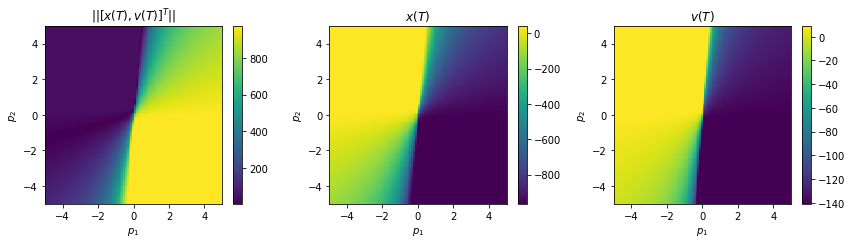

In [51]:
X,Y = np.meshgrid(grid, grid)
fig, ax = plt.subplots(1,3, figsize=(12,3.5))

im1 = ax[0].pcolormesh(X,Y, np.linalg.norm(test, axis=2))
ax[0].set_title("$|| [x(T), v(T)]^T ||$")
fig.colorbar(im1, ax=ax[0])

im2 = ax[1].pcolormesh(X,Y, test[:,:,0])
ax[1].set_title("$x(T)$")
fig.colorbar(im2, ax=ax[1])

im3 = ax[2].pcolormesh(X,Y, test[:,:,1])
ax[2].set_title("$v(T)$")
fig.colorbar(im3, ax=ax[2])

for i in range(3):
    ax[i].set_xlabel('$p_1$')
    ax[i].set_ylabel('$p_2$')
    
plt.tight_layout()
plt.savefig('search_initial_angled.png')
plt.show()

In [52]:
np.linalg.norm(test, axis=2).min()

6.017093006589576

[0.0053 0.299 ]


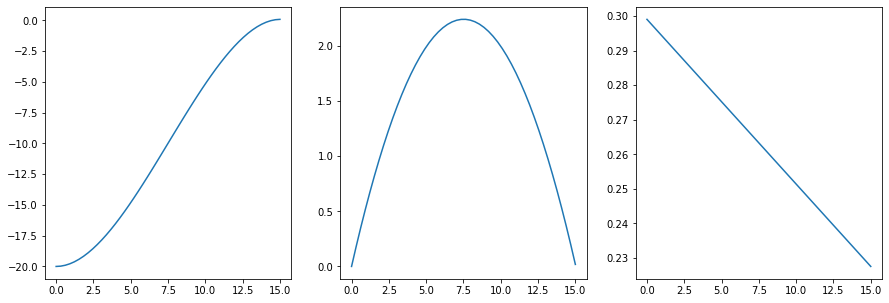

[0.0927 0.0185]
[0.0927 0.0185 0.0053 0.2276]


In [154]:
p0 = np.array([0.0071, 0.3987]) * 3/4
print(p0)
t = np.linspace(t0, 15, 50)
sol = odeint(ode, np.array([x0, v0, p0[0], p0[1]]), t, (0.25,), atol=1e-10)

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(t, sol[:,0])
plt.subplot(132)
plt.plot(t, sol[:,1])
plt.subplot(133)
plt.plot(t, sol[:,3])
plt.show()
print(func(p0, tf=15, lambda_=0.25))
print(sol[-1])

In [165]:
#intial guesses
p0 = np.array([0.0071, 0.3987])
T = np.geomspace(8.5, 15, 150)[::-1]

In [166]:
#solve 
lambdas = [0, 0.25, 0.5, 0.75, 0.9] # values in [0, 1)
costs = []
p0ss = []
for lambda_ in lambdas:
    print(f"Starting lambda={lambda_}", end=' ')
    cost, p0s = find_costs(p0 * (1 - lambda_), T, func, lambda_, display=True)
    costs.append(cost)
    p0ss.append(p0s)
    print(f"Finished.")

tf: 15.0, x0,v0: [0.0016 0.0003], p0: [0.0071 0.3987]:   4%|▍         | 42/1000 [00:00<00:04, 219.49it/s]

Starting lambda=0 

tf: 15.0, x0,v0: [9.0699e-06 1.7889e-06], p0: [0.0071 0.3987]:  10%|▉         | 98/1000 [00:00<00:04, 214.17it/s]
tf: 14.9429, x0,v0: [-9.7648e-06  1.6553e-06], p0: [0.0072 0.399 ]:  10%|▉         | 97/1000 [00:00<00:03, 233.21it/s]
tf: 14.8861, x0,v0: [8.5112e-06 3.2896e-06], p0: [0.0073 0.3994]:   6%|▌         | 56/1000 [00:00<00:04, 224.40it/s]
tf: 14.8294, x0,v0: [8.7591e-06 3.3198e-06], p0: [0.0074 0.3998]:   6%|▌         | 56/1000 [00:00<00:04, 208.47it/s]
tf: 14.773, x0,v0: [8.8336e-06 3.8835e-06], p0: [0.0074 0.4002]:   5%|▌         | 54/1000 [00:00<00:06, 141.20it/s]
tf: 14.7168, x0,v0: [-8.9606e-06  3.6109e-06], p0: [0.0075 0.4005]:   5%|▌         | 51/1000 [00:00<00:08, 113.70it/s]
tf: 14.6608, x0,v0: [-9.7081e-06  2.2351e-06], p0: [0.0076 0.4009]:   6%|▌         | 55/1000 [00:00<00:07, 122.45it/s]
tf: 14.605, x0,v0: [-9.6952e-06  2.2415e-06], p0: [0.0077 0.4013]:   6%|▌         | 55/1000 [00:00<00:07, 130.83it/s]
tf: 14.5495, x0,v0: [-8.9407e-06  2.0622e-06], p0: [0.0078 0.

Done
Finished.
Starting lambda=0.25 

tf: 15.0, x0,v0: [9.1129e-06 1.7889e-06], p0: [0.0053 0.299 ]:  10%|▉         | 98/1000 [00:00<00:03, 227.44it/s]
tf: 14.9429, x0,v0: [-8.8770e-06  1.5063e-06], p0: [0.0054 0.2993]:  10%|▉         | 98/1000 [00:00<00:04, 217.30it/s]
tf: 14.8861, x0,v0: [8.6887e-06 3.2881e-06], p0: [0.0055 0.2996]:   6%|▌         | 56/1000 [00:00<00:04, 221.98it/s]
tf: 14.8294, x0,v0: [8.9439e-06 3.3205e-06], p0: [0.0055 0.2998]:   6%|▌         | 56/1000 [00:00<00:04, 213.50it/s]
tf: 14.773, x0,v0: [8.8336e-06 3.8836e-06], p0: [0.0056 0.3001]:   5%|▌         | 54/1000 [00:00<00:06, 139.75it/s]
tf: 14.7168, x0,v0: [-8.963e-06  3.611e-06], p0: [0.0056 0.3004]:   5%|▌         | 51/1000 [00:00<00:08, 117.98it/s]  
tf: 14.6608, x0,v0: [-9.7078e-06  2.2352e-06], p0: [0.0057 0.3007]:   6%|▌         | 55/1000 [00:00<00:07, 120.58it/s]
tf: 14.605, x0,v0: [-9.6952e-06  2.2415e-06], p0: [0.0058 0.301 ]:   6%|▌         | 55/1000 [00:00<00:07, 129.71it/s]
tf: 14.5495, x0,v0: [-8.8824e-06  2.0656e-06], p0: [0.0058 0.

Done
Finished.
Starting lambda=0.5 

tf: 15.0, x0,v0: [8.9296e-06 1.7889e-06], p0: [0.0036 0.1993]:  10%|▉         | 98/1000 [00:00<00:03, 244.28it/s]
tf: 14.9429, x0,v0: [-9.0369e-06  1.5063e-06], p0: [0.0036 0.1995]:  10%|▉         | 98/1000 [00:00<00:03, 250.10it/s]
tf: 14.8861, x0,v0: [9.3193e-06 3.6133e-06], p0: [0.0036 0.1997]:   6%|▌         | 55/1000 [00:00<00:03, 240.53it/s]
tf: 14.8294, x0,v0: [8.7748e-06 3.3237e-06], p0: [0.0037 0.1999]:   6%|▌         | 56/1000 [00:00<00:04, 233.01it/s]
tf: 14.773, x0,v0: [8.8395e-06 3.8823e-06], p0: [0.0037 0.2001]:   5%|▌         | 54/1000 [00:00<00:06, 148.59it/s]
tf: 14.7168, x0,v0: [-8.9688e-06  3.6109e-06], p0: [0.0038 0.2003]:   5%|▌         | 51/1000 [00:00<00:07, 121.25it/s]
tf: 14.6608, x0,v0: [-9.7085e-06  2.2351e-06], p0: [0.0038 0.2005]:   6%|▌         | 55/1000 [00:00<00:07, 126.12it/s]
tf: 14.605, x0,v0: [-9.6955e-06  2.2415e-06], p0: [0.0039 0.2007]:   6%|▌         | 55/1000 [00:00<00:06, 135.82it/s]
tf: 14.5495, x0,v0: [-8.8862e-06  2.0654e-06], p0: [0.0039 0.

Done
Finished.
Starting lambda=0.75 

tf: 15.0, x0,v0: [9.0872e-06 1.7889e-06], p0: [0.0018 0.0997]:  10%|▉         | 98/1000 [00:00<00:04, 222.61it/s]
tf: 14.9429, x0,v0: [-9.0650e-06  1.5063e-06], p0: [0.0018 0.0998]:  10%|▉         | 98/1000 [00:00<00:03, 243.13it/s]
tf: 14.8861, x0,v0: [8.4692e-06 3.2881e-06], p0: [0.0018 0.0999]:   6%|▌         | 56/1000 [00:00<00:03, 246.36it/s]
tf: 14.8294, x0,v0: [8.7852e-06 3.3234e-06], p0: [0.0018 0.0999]:   6%|▌         | 56/1000 [00:00<00:03, 238.97it/s]
tf: 14.773, x0,v0: [8.9403e-06 3.8916e-06], p0: [0.0019 0.1   ]:   5%|▌         | 54/1000 [00:00<00:06, 141.84it/s]
tf: 14.7168, x0,v0: [-8.7829e-06  3.6114e-06], p0: [0.0019 0.1001]:   5%|▌         | 51/1000 [00:00<00:07, 125.50it/s]
tf: 14.6608, x0,v0: [-9.7107e-06  2.2350e-06], p0: [0.0019 0.1002]:   6%|▌         | 55/1000 [00:00<00:07, 133.92it/s]
tf: 14.605, x0,v0: [-9.6971e-06  2.2415e-06], p0: [0.0019 0.1003]:   6%|▌         | 55/1000 [00:00<00:06, 140.76it/s]
tf: 14.5495, x0,v0: [-8.8845e-06  2.0655e-06], p0: [0.0019 0.

Done
Finished.
Starting lambda=0.9 

tf: 15.0, x0,v0: [8.7634e-06 1.7889e-06], p0: [0.0007 0.0399]:  10%|▉         | 98/1000 [00:00<00:03, 243.09it/s]
tf: 14.9429, x0,v0: [-9.7622e-06  1.6553e-06], p0: [0.0007 0.0399]:  10%|▉         | 97/1000 [00:00<00:03, 247.09it/s]
tf: 14.8861, x0,v0: [8.6956e-06 3.2960e-06], p0: [0.0007 0.0399]:   6%|▌         | 56/1000 [00:00<00:03, 236.13it/s]
tf: 14.8294, x0,v0: [9.0852e-06 3.3422e-06], p0: [0.0007 0.04  ]:   6%|▌         | 56/1000 [00:00<00:03, 247.22it/s]
tf: 14.773, x0,v0: [8.4875e-06 3.5681e-06], p0: [0.0007 0.04  ]:   6%|▌         | 55/1000 [00:00<00:06, 151.03it/s]
tf: 14.7168, x0,v0: [-8.5583e-06  3.6388e-06], p0: [0.0008 0.0401]:   5%|▌         | 51/1000 [00:00<00:07, 122.68it/s]
tf: 14.6608, x0,v0: [-9.7031e-06  2.2378e-06], p0: [0.0008 0.0401]:   6%|▌         | 55/1000 [00:00<00:07, 132.30it/s]
tf: 14.605, x0,v0: [-9.7105e-06  2.2412e-06], p0: [0.0008 0.0401]:   6%|▌         | 55/1000 [00:00<00:06, 145.39it/s]
tf: 14.5495, x0,v0: [-8.8990e-06  2.0651e-06], p0: [0.0008 0.

Done
Finished.


tf: 14.7168, x0,v0: [-0.0006  0.0002], p0: [0.0038 0.2003]:   1%|          | 7/1000 [14:37<34:35:35, 125.41s/it]
tf: 14.7168, x0,v0: [-3.3306e-05  1.3527e-05], p0: [0.0019 0.1001]:   4%|▎         | 36/1000 [14:33<6:29:54, 24.27s/it]


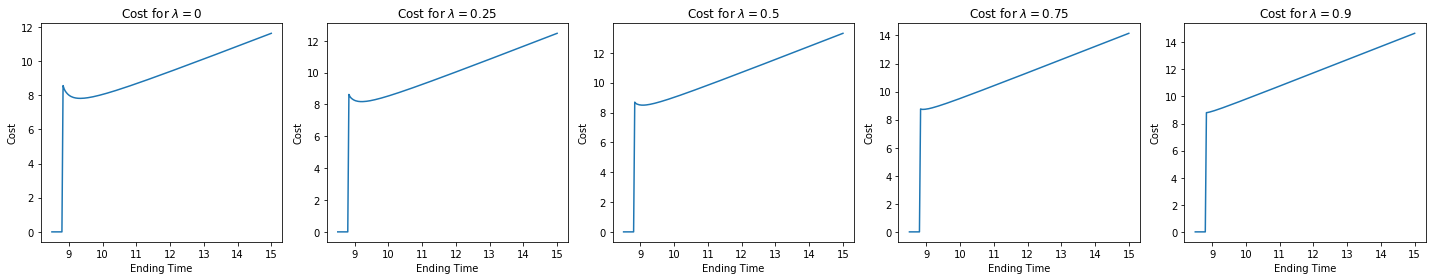

In [167]:
plt.figure(figsize=(4*len(lambdas),4))
for i, lambda_ in enumerate(lambdas):
    plt.subplot(1,len(lambdas),i+1)
    plt.plot(T, costs[i])
    pltAttr("Ending Time", "Cost", rf"Cost for $\lambda = {lambda_}$")
    
plt.savefig("cost_change_angled.pdf", bbox_inches="tight")
plt.show()

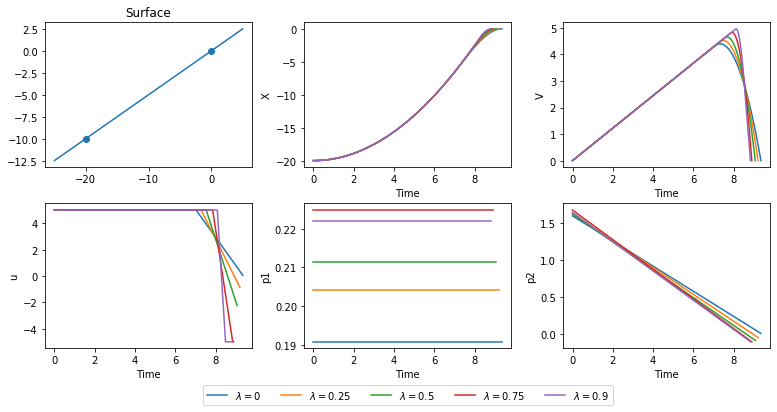

In [169]:
#find index of best cost
min_idx = [np.where(cost==np.min(cost[np.nonzero(cost)]))[0][0] for cost in costs]

fig, ax = plt.subplots(2, 3, figsize=(13,6))
for i, (idx, lambda_) in enumerate(zip(min_idx, lambdas)):

    p0 = p0ss[i][idx]
    t = np.linspace(t0, T[idx], 500)

    sol = odeint(ode, np.array([x0, v0, p0[0], p0[1]]), t, (lambda_,), atol=1e-10)
    ax[0,1].plot(t, sol[:,0])
    ax[0,2].plot(t, sol[:,1])
    ax[1,1].plot(t, sol[:,2], label=rf"$\lambda={lambda_}$")
    ax[1,2].plot(t, sol[:,3])

    ones = np.ones_like(sol[:,3])
    ax[1,0].plot(t, np.minimum(np.maximum(ones*min_u, sol[:,3]*25 / (2*(1-lambda_))), ones*max_u))

ax[1,1].legend(loc='center', ncol=len(lambdas), bbox_to_anchor= (0.5, -0.32))
ax[0,1].set_ylabel('X')
ax[0,2].set_ylabel('V')
ax[1,0].set_ylabel('u') 
ax[1,1].set_ylabel('p1')    
ax[1,2].set_ylabel('p2')    
for i in ax.flatten()[1:]:
    i.set_xlabel("Time")

x = np.linspace(x0-5,0+5,100)
ax[0,0].plot(x, f_lam(x))
temp = np.array([x0, 0])
ax[0,0].scatter(temp, f_lam(temp))
ax[0,0].set_title("Surface")

# plt.tight_layout()
fig.subplots_adjust(wspace=0.25, hspace=0.25)
plt.savefig("solution_angled.pdf", bbox_inches="tight")
plt.show()